My girlfriend recently accused me of taking a long time to reply over text message, supposedly longer than her. This made me wonder about the actual numbers. To answer this question I would need to accesss the metadata from my imessages.. I was not entirely sure how to do this, but upon searching around for how to get these data I found a brilliant app by Ryan D'souza, the [iMessageAnalyzer](https://github.com/dsouzarc/iMessageAnalyzer). This allowed me to quickly download a csv of my conversation of interest.

Here I will explore the average time it takes me to reply to my girlfriend over iMessage. The data have been masked so that my name is 'me', and my girlfriend is 'gf'; the column containing the text message at each time point was removed.

In [1]:
import pandas as pd 

In [2]:
gf_txt = pd.read_csv('gftxt.csv', names=['person', 'time'], parse_dates=True, header=1)

It looks like all the information I need is in the first two columns: 'person' and 'time'. I'll store a new instance of the data frame. 

In [3]:
gf_txt.head()

,person,time
1,gf,2015-06-21 21:56:16 +0000
2,me,2015-06-21 22:00:32 +0000
3,gf,2015-07-28 18:15:08 +0000
4,me,2015-07-28 19:15:06 +0000
5,me,2015-07-28 19:15:16 +0000


In [4]:
gf_txt.dtypes

person    object
time      object
dtype: object

Looks like I need to change the time column to datetime!

In [5]:
gf_txt['time'] = pd.to_datetime(gf_txt['time'])
gf_txt2 = gf_txt.copy()

In [6]:
gf_txt.head(20)

,person,time
1,gf,2015-06-21 21:56:16
2,me,2015-06-21 22:00:32
3,gf,2015-07-28 18:15:08
4,me,2015-07-28 19:15:06
5,me,2015-07-28 19:15:16
6,gf,2015-07-28 19:33:53
7,me,2015-07-28 20:02:39
8,me,2015-07-28 21:42:38
9,gf,2015-07-29 05:13:23
10,me,2015-07-29 05:14:40


In [7]:
gf_txt.dtypes

person            object
time      datetime64[ns]
dtype: object

It is evident sometimes one person texts the other twice, three times, etc... I only want the difference between rows where 'person' changes. To do this I will create a new row called pdiff which is just person shifted up so that I can compare the next row (pnext) to the current row (person). Then I need to select only rows where 'person' is not equal to 'pnext'.

In [8]:
# create pnext that is shifted version of person
gf_txt['pnext'] = gf_txt.person.shift(-1)

# make new dataframe where each row is a change in the person who is texting
gf_alt = gf_txt.loc[gf_txt['person'] != gf_txt['pnext']].copy()
gf_alt.head()

,person,time,pnext
1,gf,2015-06-21 21:56:16,me
2,me,2015-06-21 22:00:32,gf
3,gf,2015-07-28 18:15:08,me
5,me,2015-07-28 19:15:16,gf
6,gf,2015-07-28 19:33:53,me


Great, now I can compute the time difference between the two entries. 

In [9]:
# compute time difference in seconds as new column
gf_alt['tdiff'] = gf_alt['time'].diff().dt.seconds.div(60, fill_value = 0)
gf_alt.head()

,person,time,pnext,tdiff
1,gf,2015-06-21 21:56:16,me,0.000000
2,me,2015-06-21 22:00:32,gf,4.266667
3,gf,2015-07-28 18:15:08,me,1214.600000
5,me,2015-07-28 19:15:16,gf,60.133333
6,gf,2015-07-28 19:33:53,me,18.616667


The dataframe now has column 'tdiff' representing the time in minutes since the last person. Becasue I have ensured that persons are truely alternating, the 'tdiff' column represents the reply time for the current person. Let's see each person's average reply time since 2015.

In [10]:
gf_alt[gf_alt['person'] == 'me'].mean()

tdiff    134.83797
dtype: float64

In [11]:
gf_alt[gf_alt['person'] == 'gf'].mean()

tdiff    159.375923
dtype: float64

It appears I have the faster reply time since 2015... interesting. What do these data look like as a graph? 

In [12]:
%matplotlib inline

In [13]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates 

In [14]:
import seaborn as sns


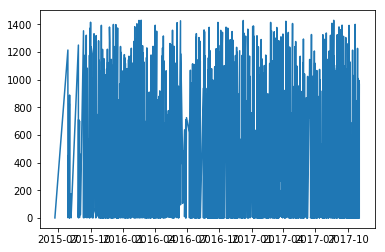

In [15]:
plt.plot(gf_alt['time'], gf_alt['tdiff'])

This does not help. Maybe a montly average will do.

In [16]:
# select columns of interest
gf_tdex = gf_alt.filter(['person','tdiff', 'time'])
gf_tdex.head()

,person,tdiff,time
1,gf,0.000000,2015-06-21 21:56:16
2,me,4.266667,2015-06-21 22:00:32
3,gf,1214.600000,2015-07-28 18:15:08
5,me,60.133333,2015-07-28 19:15:16
6,gf,18.616667,2015-07-28 19:33:53


In [17]:
gf_monthly = gf_tdex.groupby('person').resample('M', on='time').mean().reset_index()
gf_monthly.head()
gf_monthly['time'] = gf_monthly['time'].map(lambda x: x.strftime('%Y-%m-%d'))

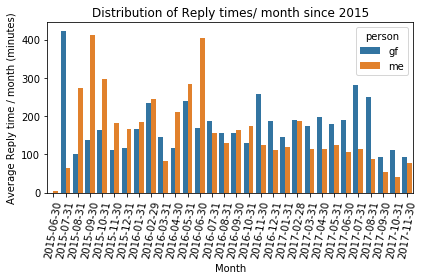

In [18]:
gf_monthly

fig, ax = plt.subplots()
sns.barplot('time', 'tdiff', data=gf_monthly, hue='person', ax=ax)
plt.xticks(rotation=80)
plt.xlabel('Month')
plt.ylabel('Average Reply time / month (minutes)')
plt.title('Distribution of Reply times/ month since 2015')
plt.tight_layout()
plt.savefig('replytimes.png', dpi=1000)

Ahh, this is more revealing! I was slower to reply each month on averaage from August 2015 until July 2016 when I became faster at replying to text messages on average every month. What this analysis overlooks is the difference in overnight text messages. The times that we really care about in terms of the 'time to reply' are only in the day time, and overnight time to reply could be skewing these averages. So I will remove texts form between 10pm and 6 am, then take the average reply times for this subset. 

In [19]:
# new column with only date
gf_txt2['date'] = gf_txt2['time'].map(lambda x: str(x).split()[0])

# new column with only time
gf_txt2['hour'] = pd.to_timedelta(gf_txt2['time'].map(lambda x: str(x).split()[1]))

# set time mask 
mask = (gf_txt2['hour'] < pd.to_timedelta('22:00:00')) & (gf_txt2['hour'] > pd.to_timedelta('06:00:00'))
gf_daytime = gf_txt2[mask]

gf_daytime.head()

,person,time,date,hour
1,gf,2015-06-21 21:56:16,2015-06-21,21:56:16
3,gf,2015-07-28 18:15:08,2015-07-28,18:15:08
4,me,2015-07-28 19:15:06,2015-07-28,19:15:06
5,me,2015-07-28 19:15:16,2015-07-28,19:15:16
6,gf,2015-07-28 19:33:53,2015-07-28,19:33:53


Filtering based on time like this made it so there were some repetative persons again, this can be fixed with a shift the same way it was before. 

In [20]:
# create pnext that is shifted version of person
gf_daytime['pnext2'] = gf_daytime.person.shift(-1)

# make new dataframe where each row is a change in the person who is texting
gf_daytime = gf_daytime.loc[gf_daytime['person'] != gf_daytime['pnext2']]
gf_daytime.head()

# groupby date to remove diffs that carry over a day
group = gf_daytime.groupby(by='date')

# compute time difference in seconds as new column
gf_daytime['tdiff'] = group['time'].diff().dt.seconds.div(60, fill_value = 0)
gf_daytime.head(20)

# Select only non-zero rows
gf_daytime = gf_daytime[gf_daytime['tdiff'] != 0]

/Users/JakeVanCampen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


The reply times that carry over a day need to be removed. 

Now the same monthly resampled averageing can be done and summarized in a plot.

My average reply time since 2015 between 6am and 10pm: 42.28 minutes.
Gf's average reply time since 2015 between 6am and 10pm: 53.08 minutes.


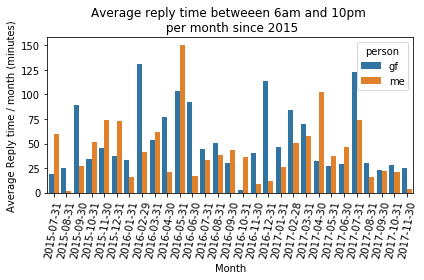

In [21]:
# select columns of interest
gf_daytime = gf_daytime.filter(['person','tdiff', 'time'])

gf_monthly2 = gf_daytime.groupby('person').resample('M', on='time').mean().reset_index()
gf_monthly2.head()
gf_monthly2['time'] = gf_monthly2['time'].map(lambda x: x.strftime('%Y-%m-%d'))


fig, ax = plt.subplots()
sns.barplot('time', 'tdiff', data=gf_monthly2, hue='person', ax=ax)
plt.xticks(rotation=80)
plt.xlabel('Month')
plt.ylabel('Average Reply time / month (minutes)')
plt.title('Average reply time betweeen 6am and 10pm \n per month since 2015')
plt.tight_layout()
plt.savefig('replytimes_day.png', dpi=1000)

print("My average reply time since 2015 between 6am and 10pm: " +
      str(round(gf_monthly2[gf_monthly2['person'] == 'me'].mean()[0], 2))  + " minutes.")

print("Gf's average reply time since 2015 between 6am and 10pm: " +
      str(round(gf_monthly2[gf_monthly2['person'] == 'gf'].mean()[0], 2)) + " minutes.")


Filtering out the nights, and removing overnight replies certainly changed the structure of the data. The overall averages suggest only a difference in reply time of about 6 minutes between gf and I. The graph also shows more clearly certain months that have greater or smaller reply times on both of our parts. Given this new graph, I'd say it's about even!